In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "stock_details_5_years.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "iveeaten3223times/massive-yahoo-finance-dataset",
  file_path,
)

print("First 5 records:", df.head())

<ipython-input-1-a1b03db844d5>:6: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:                         Date        Open        High         Low       Close  \
0  2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508   
1  2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131   
2  2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000   
3  2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497   
4  2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853   

      Volume  Dividends  Stock Splits Company  
0  167080000       0.00           0.0    AAPL  
1   28123200       0.00           0.0    MSFT  
2   31004000       0.00           0.0   GOOGL  
3  132264000       0.00           0.0    AMZN  
4   54917200       0.04           0.0    NVDA  


In [ ]:
import pandas as pd

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date (important for time-series)
df = df.sort_values('Date')

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values (if any)
df = df.dropna()  # or use interpolation: df.interpolate()

# Set 'Date' as index (useful for time-series analysis)
df.set_index('Date', inplace=True)

# Keep only relevant columns (adjust as needed)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
print("\nProcessed DataFrame:")
print(df.head())

<ipython-input-2-3365c314cf14>:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])



Missing values:
Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Company         0
dtype: int64

Processed DataFrame:
                                Open       High        Low      Close  \
Date                                                                    
2018-11-29 00:00:00-05:00  43.829761  43.863354  42.639594  43.083508   
2018-11-29 00:00:00-05:00  75.903743  76.029017  75.142496  75.450851   
2018-11-29 00:00:00-05:00  56.789875  56.789875  56.789875  56.789875   
2018-11-29 00:00:00-05:00  37.257999  37.367001  36.585999  37.042999   
2018-11-29 00:00:00-05:00  13.439500  14.347000  13.439500  14.081000   

                              Volume  
Date                                  
2018-11-29 00:00:00-05:00  167080000  
2018-11-29 00:00:00-05:00     466800  
2018-11-29 00:00:00-05:00        300  
2018-11-29 00:00:00-05:00    1853000  
2018-11-29 00:00:00-05:00   15479000  


In [ ]:
import numpy as np

# Calculate SMA (20-day window)
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Calculate EMA (20-day window)
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Calculate RSI (14-day window)
delta = df['Close'].diff(1)
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate Bollinger Bands (20-day window, 2 std dev)
df['Upper_Band'] = df['SMA_20'] + (2 * df['Close'].rolling(20).std())
df['Lower_Band'] = df['SMA_20'] - (2 * df['Close'].rolling(20).std())

print("\nData with Indicators:")
print(df.tail())


Data with Indicators:
                                 Open        High         Low       Close  \
Date                                                                        
2023-11-29 00:00:00-05:00   91.220001   91.684998   90.919998   90.980003   
2023-11-29 00:00:00-05:00  470.279999  471.410614  464.440002  467.255005   
2023-11-29 00:00:00-05:00  274.600006  276.049988  274.390015  275.635010   
2023-11-29 00:00:00-05:00   65.650002   65.970001   65.260002   65.709999   
2023-11-29 00:00:00-05:00   84.629997   84.995003   83.529999   83.889999   

                            Volume      SMA_20      EMA_20        RSI  \
Date                                                                    
2023-11-29 00:00:00-05:00   962390  162.198750  199.908729  45.674550   
2023-11-29 00:00:00-05:00   222279  182.623251  225.370279  53.281808   
2023-11-29 00:00:00-05:00   299304  189.441501  230.157396  56.365209   
2023-11-29 00:00:00-05:00  1184237  189.616501  214.495739  51.343592   

In [ ]:
from sklearn.ensemble import IsolationForest

# Prepare features (use price + indicators)
features = df[['Close', 'SMA_20', 'RSI', 'Volume']]

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)  # 5% anomalies
df['Anomaly_IF'] = model.fit_predict(features)

# Mark anomalies (1=normal, -1=anomaly)
df['Anomaly_IF'] = df['Anomaly_IF'].apply(lambda x: 1 if x == 1 else -1)

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

# Split into train/test
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict and inverse transform
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Calculate errors (MSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(scaler.inverse_transform(y_test), test_pred)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - loss: 0.0016
Epoch 2/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - loss: 0.0014
Epoch 3/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - loss: 0.0012
Epoch 4/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - loss: 0.0011
Epoch 5/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 143s 6ms/step - loss: 7.4495e-04
Epoch 6/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - loss: 5.5512e-04
Epoch 7/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 87s 6ms/step - loss: 4.5988e-04
Epoch 8/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 87s 6ms/step - loss: 3.5372e-04
Epoch 9/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 87s 6ms/step - loss: 2.8254e-04
Epoch 10/10
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - loss: 2.5888e-04
15074/15074 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Test MSE: 70501.41729250205


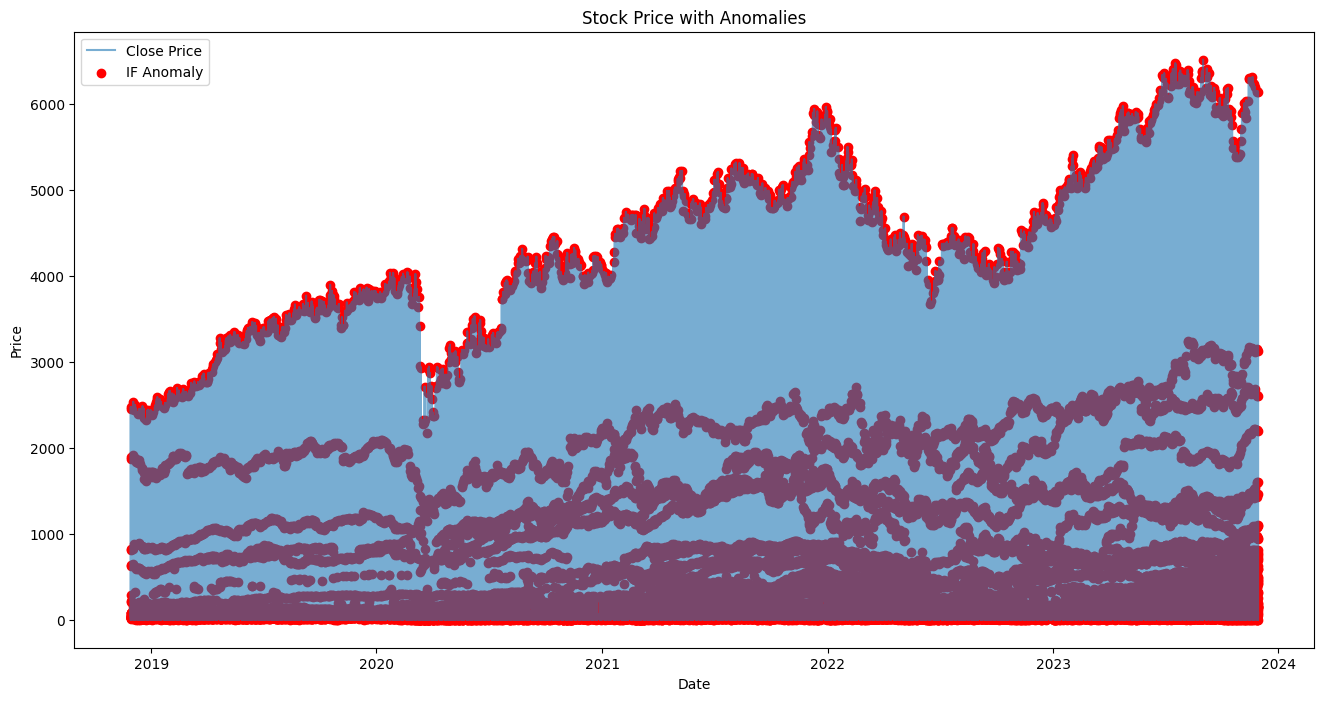

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.6)

# Highlight Isolation Forest anomalies
anomalies_if = df[df['Anomaly_IF'] == -1]
plt.scatter(anomalies_if.index, anomalies_if['Close'], color='red', label='IF Anomaly')

plt.title('Stock Price with Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()